In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import scipy
import itertools
from scipy.stats import truncnorm

## Code for simulation

In [2]:
class Person:
    '''
    Models a single person that will act as a node
    '''
    
    def __init__(self, alpha=0.03, beta=0.3, gamma=4, 
                 topics={'soccer':0.3}):
        '''
        Input:
            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            topics (dict)
                key => name of the topic
                value => opinion on that topic
        '''
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.topics = topics


class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    
    ** The following code is a modified version of code provided in 
       session 7.2 has been used and modified.
    '''
    def __init__(self, network_size=50, 
                 dist_alpha=[truncnorm.rvs, (0, 0.5, 0.03, 0.0001)],
                 dist_beta=[truncnorm.rvs, (0, 1, 0.3, 0.0001)],
                 dist_gamma=[truncnorm.rvs, (0, 4.3, 4, 0.0001)],
                 list_topics = ['soccer', 'politics'],
                 ratio_topic_discussion = [1,20],
                 list_func_graph = [nx.barabasi_albert_graph, [3]]
                ):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Barabasi Albert graph. 
                Default: 50.
            
            dist_alpha (list) 
                1st element (function): the function for generating alpha from a distribution 
                2nd element (set): is the parameters for distribution function.
                Generates 'alpha' that is the rate at which nodes adjust their
                opinions to match neighboring nodes' opinions.
                Default: [truncnorm.rvs, (0, 0.5, 0.03, 0.0001)]
            
            dist_beta (list) 
                1st element (function): the function for generating beta from a distribution 
                2nd element (set): is the parameters for distribution function.
                * Generates 'beta' -> The rate at which edge weights are changed
                  in response to differing opinions
                Default: [truncnorm.rvs, (0, 1, 0.3, 0.0001)]
                
            dist_gamma (list) 
                1st element (function): the function for generating alpha from a distribution 
                2nd element (set): is the parameters for distribution function.
                * Generates 'gamma' -> The openness paramter, that shows the effect
                  in difference of opinions on edge weight. Nodes with opinions 
                  differing by more than 1/gamma will result in decrese of weight.
                Default: [truncnorm.rvs, (0, 4.3, 4, 0.0001)]
            
            lst_topics (list) The list of topics that each person will have opinion on.
                Default: ['soccer', 'politics']
                
            ratio_topic_discussion (list) The ratio of discussion of each topic or popularity of
                each topic. If the value is [1, 20], 2nd topic is 20 times more popular than 1st topic and 
                has probability of 20/21 for being chosen for discussion.
                Default: [1, 20]
                
            list_func_graph (list) 
                1st element (function): The function for creating the graph
                2nd element (set): The parameters except network size for the graph function 
                Default: [nx.barabasi_albert_graph, [3]]
        '''
        self.network_size = network_size
        self.dist_alpha = dist_alpha
        self.dist_beta = dist_beta
        self.dist_gamma = dist_gamma
        self.list_topics = list_topics
        self.ratio_topic_discussion = ratio_topic_discussion
        self.list_func_graph = list_func_graph
        
        # normalizing the ratio for discussion to get their probabilities
        self.p_opinions = np.array(ratio_topic_discussion)/sum(ratio_topic_discussion)
    
        # Calculating cumulative probability for using inverse cdf for chosing each parameter
        self.p_cumsum = scipy.cumsum(self.p_opinions)
        
        self.initialize()
        
    
    def _generate_person(self):
        '''
            Creates a Person object based on given parameters
        '''
        topics = {} # Dict to store topic and the opinion on that topic
        
        for topic in self.list_topics:
            # For each topic randomly generating a opinion value
            # Initializes topic to random 0 or 1
            topics[topic] = float(random.randint(0,1))
        
        alpha = self.dist_alpha[0](*self.dist_alpha[1])
        beta = self.dist_beta[0](*self.dist_beta[1])
        gamma = self.dist_gamma[0](*self.dist_gamma[1])
        
        person = Person(alpha, beta, gamma, topics)
        
        return person
        

    def initialize(self):
        '''
        Initialize the simulation with a random graph, each node has an Person key
        and Person class as a value pair
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = self.list_func_graph[0](self.network_size, *self.list_func_graph[1])
        
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        
        for node in self.graph.nodes:
            self.graph.nodes[node]['Person'] = self._generate_person()
        
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=20)
        
        # Ploting opinions in each topic side by side
        str_subplot = str('1' + str(len(self.list_topics)))
        ind_subplot = 1
        
        plt.clf()
        for topic in self.list_topics:
            plt.subplot(int(str_subplot + str(ind_subplot)))
            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_color=[self.graph.nodes[i]['Person'].topics[topic] for i in self.graph.nodes],
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                alpha=0.7, vmin=0, vmax=1)
            plt.title('Step: {0}, Topic: {1}'.format(self.step, topic))
            ind_subplot += 1
        plt.show()
        
    
    def update(self):
        '''
            Updates the changes in opinion and weight of nodes as each time step
        '''
        if random.uniform(0, 1) < 0.01:
            
            # Only add a new edge if the all the network is not fully connected
            # Sanity check
            num_max_edges_possible = self.network_size - (self.network_size - 1) / 2
            if len(list(self.graph.edges)) < num_max_edges_possible:
            
                # In some cases create a new edge between unconnected node.
                nodes = list(self.graph.nodes)
                while True:
                    new_edge = random.sample(nodes, 2)
                    if new_edge not in self.graph.edges:
                        break

                # Randomly picking one of the opinions based on probability of each being talked
                ind_topic = self.p_cumsum.searchsorted(random.uniform(0, 1))
                topic = self.list_topics[ind_topic]

                diff_opinion = abs(self.graph.nodes[new_edge[0]]['Person'].topics[topic] 
                                   - self.graph.nodes[new_edge[0]]['Person'].topics[topic])

                # Only create a connection when the difference in opinion is less than 0.5
                if diff_opinion < 0.5:
                    self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
                
        else:
            # Checking an edge case if there are no edges or connection
            if len(list(self.graph.edges)) > 0:
                # Select a random edge and update node opinions and edge weight
                edge = random.choice(list(self.graph.edges))
                weight = self.graph.edges[edge]['weight']
                people = [self.graph.nodes[n]['Person'] for n in edge]

                # beta and gamma is the average of betas and gammas the two people/nodes
                beta = np.mean([people[0].beta, people[1].beta])
                gamma = np.mean([people[0].gamma, people[1].gamma])

                # Chose a topic using inverse cdf based on probability of being choosen
                topic = self.list_topics[self.p_cumsum.searchsorted(random.uniform(0,1))]

                for i in [0, 1]:
                    # Opinion of each person is changed based on their own alpha
                    people[i].topics[topic] = (
                        people[i].topics[topic] + 
                        people[i].alpha * weight *
                        (people[1-i].topics[topic] - people[i].topics[topic]))

                self.graph.edges[edge]['weight'] = (
                    weight +
                    beta * weight * (1-weight) *
                    (1 - gamma * abs(people[0].topics[topic] - people[1].topics[topic])))

                # Remove very weak connections
                if self.graph.edges[edge]['weight'] < 0.05:
                    self.graph.remove_edge(*edge)
        
        self.step += 1
    
    def simulate(self, n_steps=2000, step_size=10, verbose=False, display=True):
        '''
            Runs the simulation and plots the network graph
            
            Inputs:
            
                n_steps (int) The number of steps before showing each graph
                    Default: 2000
                
                step_size (int) The number of graphs plotted in case of verbose
                    Default : 10
                
                verbose (bool) Whether or not to show graphs in after each n_steps
                    Default : False
        '''
        
        self.initialize()
        if display:
            print('-'*30)
            print('Topics = {0}'.format(','.join(self.list_topics)))
            print('Ratio of discussion = {0}'.format(':'.join(map(str, self.ratio_topic_discussion))))
        
        # Initial layout
            plt.figure()
            self.observe()
        
        opinion_variance = {}
        opinion_variance.update([(topic, [self.calc_opinion_variance(topic)]) for topic in self.list_topics])
        arr_timesteps = [0]
        
        for _ in range(step_size):
            for _ in range(n_steps):
                self.update()
                
            for topic in self.list_topics:
                opinion_variance[topic].append(self.calc_opinion_variance(topic))
            arr_timesteps.append(arr_timesteps[-1] + n_steps)
            if verbose and display:
                # If verbose = True, plot graph after each n_steps
                plt.figure()
                self.observe()
        
        if not verbose and display:
            # Final layout
            # If verbose = True, it would have been already printed inside the loop
            plt.figure()
            self.observe()
        
        if display:
            # Showing the convergence of opinion against time
            plt.figure()
            for topic in self.list_topics:  
                plt.plot(arr_timesteps, opinion_variance[topic], label='Topic: {0}'.format(topic))
            plt.xlabel('Number of steps')
            plt.ylabel('Variance in opinion')
            plt.title('Ratio of discussion/popularity = {0}'.format(':'.join(map(str, self.ratio_topic_discussion))))
            plt.legend()
            plt.show()
            print('-'*30)
        
        return (arr_timesteps, opinion_variance)
    
    def calc_opinion_variance(self, topic):
        '''
            Calculates the variance in different opinions in a single topic
            
            Inputs:
                * topic (str) The topic whose variance in the opinions is being calculated.
        '''
        arr_opinions = [self.graph.nodes[node]['Person'].topics[topic] for node in list(self.graph.nodes)]
        return np.var(arr_opinions)

## Running simulation with different parameters



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.3, Std_dev = 0.0001
Mean Gamma = 4, Std_dev = 0.0001
------------------------------
Topics = politics,soccer
Ratio of discussion = 5:30


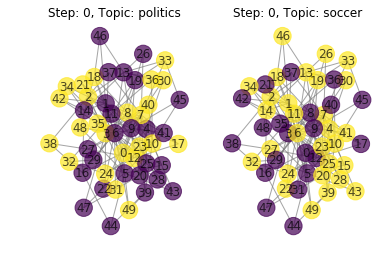

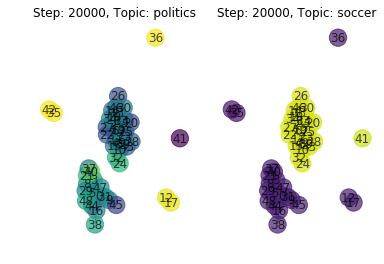

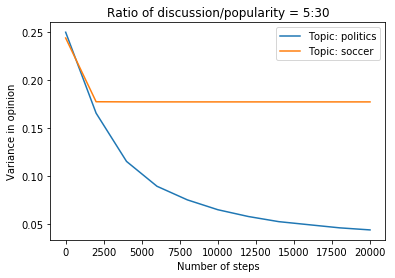

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.3, Std_dev = 0.0001
Mean Gamma = 4, Std_dev = 0.0001
------------------------------
Topics = politics,soccer
Ratio of discussion = 1:1


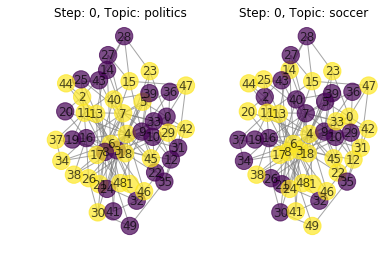

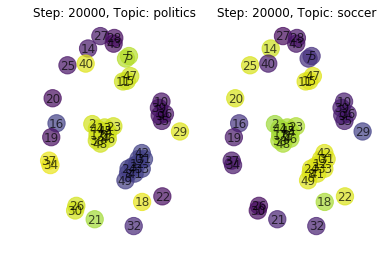

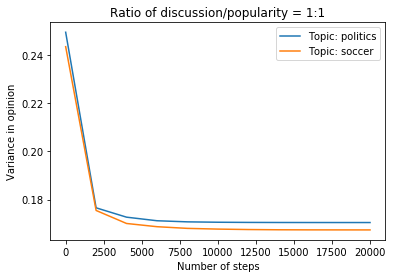

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.0001
Mean Gamma = 1, Std_dev = 0.0001
------------------------------
Topics = politics,soccer
Ratio of discussion = 5:30


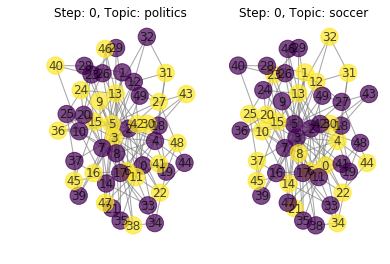

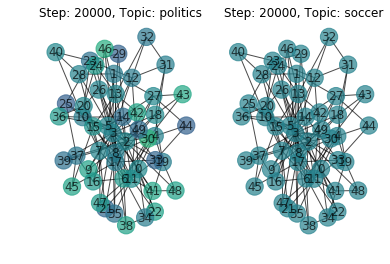

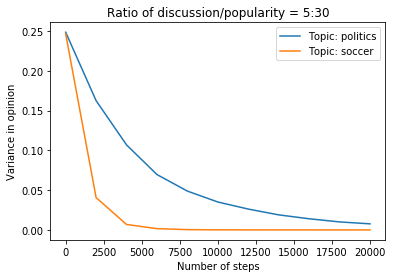

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.0001
Mean Gamma = 1, Std_dev = 0.0001
------------------------------
Topics = politics,soccer
Ratio of discussion = 1:1


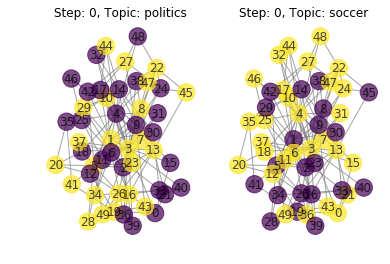

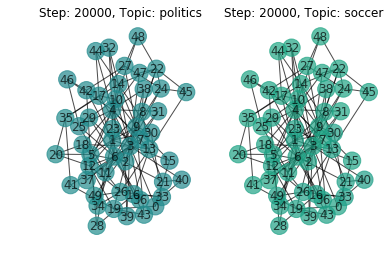

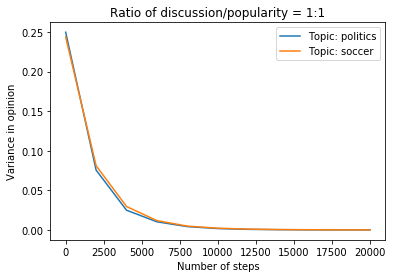

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.01, Std_dev = 0.005
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
------------------------------
Topics = politics,soccer
Ratio of discussion = 5:30


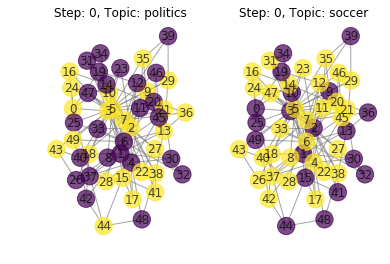

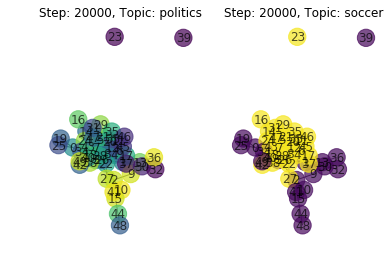

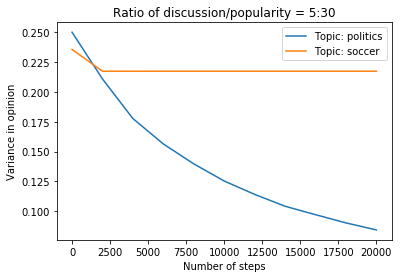

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.01, Std_dev = 0.005
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
------------------------------
Topics = politics,soccer
Ratio of discussion = 1:1


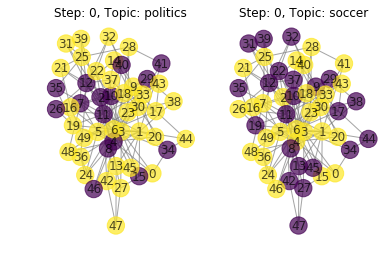

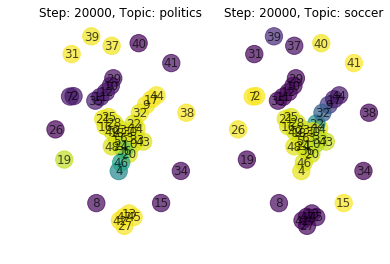

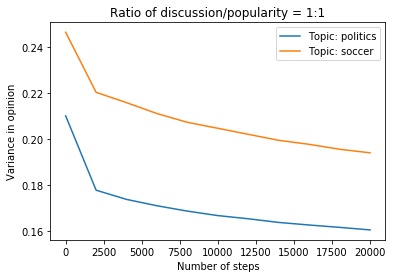

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.1, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
------------------------------
Topics = politics,soccer
Ratio of discussion = 5:30


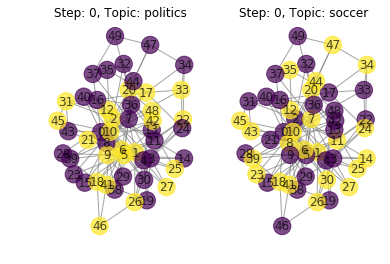

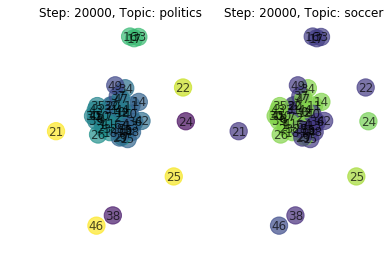

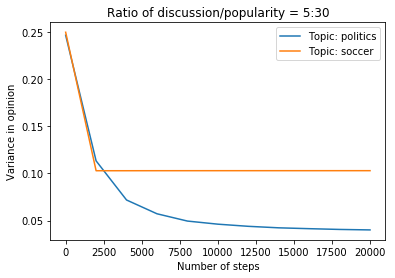

------------------------------


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.1, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
------------------------------
Topics = politics,soccer
Ratio of discussion = 1:1


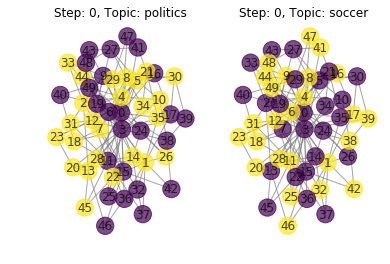

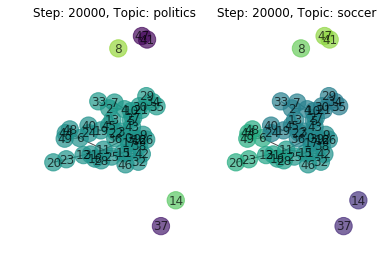

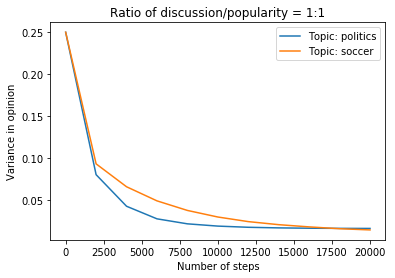

------------------------------


In [4]:
list_param_dicts = [
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.03, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.3, 0.0001)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 4, 0.0001)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.03, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.0001)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 1, 0.0001)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.01, 0.005)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.2)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 3, 1)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.1, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.2)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 3, 1)]
    }
] # Bunch of distribution with different parameters to test the simulation

list_topics = ['politics', 'soccer'] # list of topics 
list_ratio_topic_discussion = [[5, 30], [1, 1]] # distribution of topics

for dict_param in list_param_dicts:
    for ratio_topic_discussion in list_ratio_topic_discussion:
        print('\n')
        print('++'*30)
        print('Mean Alpha = {0}, Std_dev = {1}'.format(dict_param['dist_alpha'][1][2], dict_param['dist_alpha'][1][3]))
        print('Mean Beta = {0}, Std_dev = {1}'.format(dict_param['dist_beta'][1][2], dict_param['dist_beta'][1][3]))
        print('Mean Gamma = {0}, Std_dev = {1}'.format(dict_param['dist_gamma'][1][2], dict_param['dist_beta'][1][3]))
        sim = SocialDynamicsSimulation(network_size=50,
                                       **dict_param,
                                       list_topics=list_topics,
                                       ratio_topic_discussion=ratio_topic_discussion
                                      )
        sim.simulate()

## Experimenting with multiple runs of simulation



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.3, Std_dev = 0.0001
Mean Gamma = 4, Std_dev = 0.0001
Topics = politics,soccer


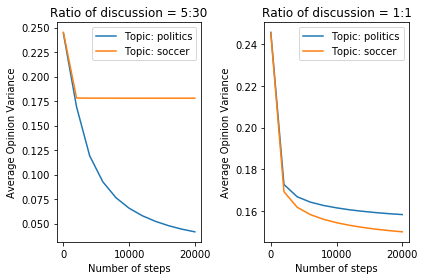



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.03, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.0001
Mean Gamma = 1, Std_dev = 0.0001
Topics = politics,soccer


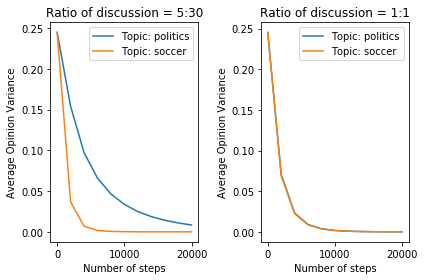



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.01, Std_dev = 0.005
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
Topics = politics,soccer


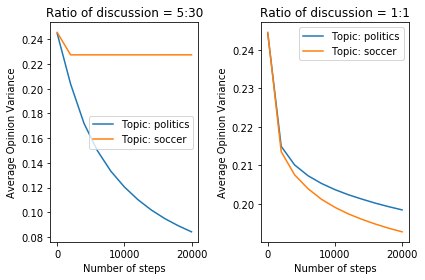



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean Alpha = 0.1, Std_dev = 0.0001
Mean Beta = 0.5, Std_dev = 0.2
Mean Gamma = 3, Std_dev = 0.2
Topics = politics,soccer


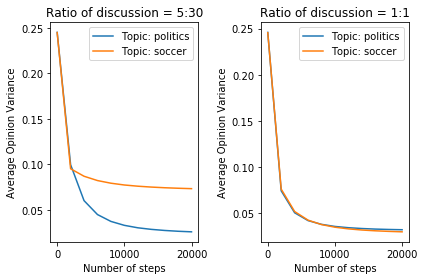

In [14]:
def run_experiment(list_param_dicts, 
                   list_topics, 
                   list_ratio_topic_discussion,
                   n_trials=100):
    '''
    Running experiment by running multiple simulation.
    
    Input:

        list_param_dicts (list) of dictionaries with functions for generating random
            numbers for alpha, beta and gamma
        
        list_topics (list) of topics that people have.
        
        list_ratio_topic_discussion (list) of ratio of popularity of each topic
        
        n_trials (int) The numbe or trials to run
    '''
    
    
    for dict_param in list_param_dicts:
        print('\n')
        print('++'*30)
        print('Mean Alpha = {0}, Std_dev = {1}'.format(dict_param['dist_alpha'][1][2], dict_param['dist_alpha'][1][3]))
        print('Mean Beta = {0}, Std_dev = {1}'.format(dict_param['dist_beta'][1][2], dict_param['dist_beta'][1][3]))
        print('Mean Gamma = {0}, Std_dev = {1}'.format(dict_param['dist_gamma'][1][2], dict_param['dist_beta'][1][3]))
        print('Topics = {0}'.format(','.join(list_topics)))
            
        for ratio_topic_discussion in list_ratio_topic_discussion:
            arr_opinion_variance = []
            
            for i in range(n_trials):
                sim = SocialDynamicsSimulation(network_size=50,
                                           **dict_param,
                                           list_topics=list_topics,
                                           ratio_topic_discussion=ratio_topic_discussion
                                          )
                
                arr_timesteps, opinion_variance = sim.simulate(display=False)
                arr_opinion_variance.append(opinion_variance)
            
            # Plotting plot
            plt.subplot(1, len(list_ratio_topic_discussion),
                        list_ratio_topic_discussion.index(ratio_topic_discussion) + 1)

            for topic in list_topics:
                
                X = [[dict_opinion_variance[topic][ind_timestep] 
                              for dict_opinion_variance in arr_opinion_variance] 
                     for ind_timestep in range(len(arr_timesteps))]
                
                plt.plot(arr_timesteps, list(map(np.mean, X)), label='Topic: {0}'.format(topic))
                plt.xlabel('Number of steps')
                plt.ylabel('Average Opinion Variance')
                plt.title('Ratio of discussion = {0}'.format(':'.join(map(str, ratio_topic_discussion))))
            plt.legend()
        plt.tight_layout()
        plt.show()


list_param_dicts = [
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.03, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.3, 0.0001)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 4, 0.0001)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.03, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.0001)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 1, 0.0001)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.01, 0.005)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.2)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 3, 1)]
    },
    {
        'dist_alpha':[truncnorm.rvs, (0, 0.5, 0.1, 0.0001)],
        'dist_beta':[truncnorm.rvs, (0, 1, 0.5, 0.2)],
        'dist_gamma':[truncnorm.rvs, (0, 4.3, 3, 1)]
    }
] # Bunch of dictionaries and random number generator functions.

list_topics = ['politics', 'soccer'] # list of topics 
list_ratio_topic_discussion = [[5, 30], [1, 1]] # distribution of topics


run_experiment(list_param_dicts, list_topics, list_ratio_topic_discussion, n_trials=100)

# Local Analysis

## Ploting vector fields for different parameters

Base Case


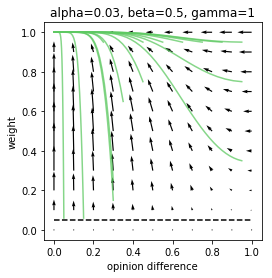

Changing Alpha only


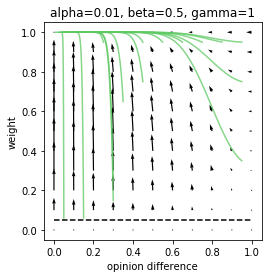

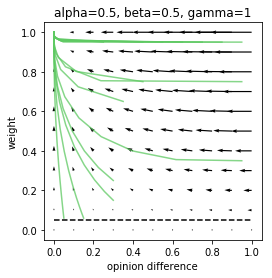

Changing Beta only


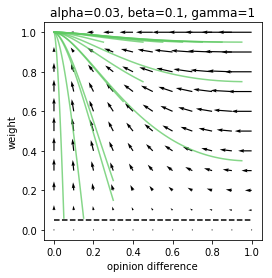

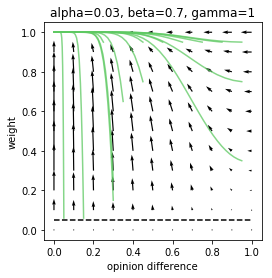

Changing Gamma only


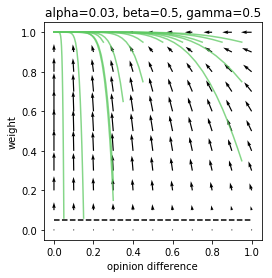

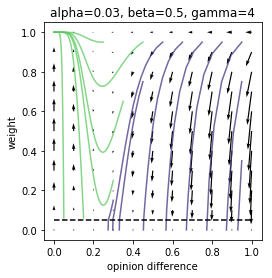

In [9]:
cmap = plt.cm.viridis  # good for color blindness

def plot_weight_and_diff_opinion(dist_opinion_weight, alpha, beta, gamma):
    '''
    Plots the vector diagram of the weights and opinions
    
    * The code is derived from Prof. Scheffler solution for class.
    
    Input:
        dist_opinion_weight (list) of (list)
            Inner list containts opiion and weight pair
        
        alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 

        beta (float) The rate at which edge weights are changed in
              response to differing opinions. 

        gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
        
    '''
    
    # Plot traces of how opinion and weight change over time
    for opinion, weight in dist_opinion_weight:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    plt.title('alpha={0}, beta={1}, gamma={2}'.format(alpha, beta, gamma))
    plt.plot([0, 1], [0.05, 0.05], 'k--')
    plt.axis('square')
    plt.show()


alpha = 0.03
beta = 0.5
gamma = 5

dist_opinion_weight = [
    [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
]

print('Base Case')
# Base case
plot_weight_and_diff_opinion(dist_opinion_weight, 0.03, 0.5, 1)

print('Changing Alpha only')
# Change Alpha
plot_weight_and_diff_opinion(dist_opinion_weight, 0.01, 0.5, 1)
plot_weight_and_diff_opinion(dist_opinion_weight, 0.5, 0.5, 1)

print('Changing Beta only')
# Change Beta
plot_weight_and_diff_opinion(dist_opinion_weight, 0.03, 0.1, 1)
plot_weight_and_diff_opinion(dist_opinion_weight, 0.03, 0.7, 1)

print('Changing Gamma only')
# Changing gamma
plot_weight_and_diff_opinion(dist_opinion_weight, 0.03, 0.5, 0.5)
plot_weight_and_diff_opinion(dist_opinion_weight, 0.03, 0.5, 4)

## Plotting the popularity effect of topics in change in opinions 

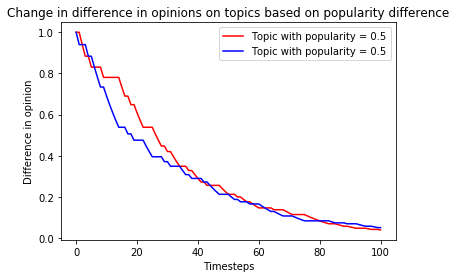

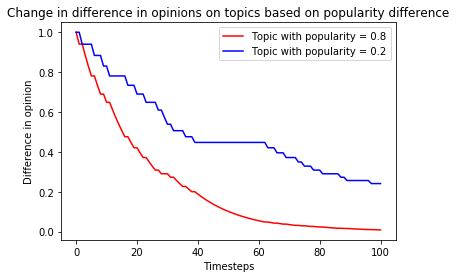

In [10]:
def plot_popularity_effect(p_popularity=0.5, alpha=0.03, weight=1):
    topics = [[[0.0, 1.0]],[[0.0, 1.0]]]

    diff_opinions = [[1.0],[1.0]]

    timesteps = [0]


    for i in range(100):
        if np.random.uniform(0, 1) < p_popularity:
            ind = 0
        else:
            ind = 1

        delta_o = alpha * weight * (topics[ind][-1][1] - topics[ind][-1][0])
        topics[ind].append([topics[ind][-1][0] + delta_o, topics[ind][-1][1] - delta_o])
        diff_opinions[ind].append(abs(topics[ind][-1][0] - topics[ind][-1][1]))
        diff_opinions[1-ind].append(diff_opinions[1-ind][-1])

        timesteps.append(timesteps[-1]+1)

    plt.plot(timesteps, diff_opinions[0], color='red', label='Topic with popularity = {0:.1f}'.format(p_popularity))
    plt.plot(timesteps, diff_opinions[1], color='blue', label='Topic with popularity = {0:.1f}'.format(1-p_popularity))
    plt.title('Change in difference in opinions on topics based on popularity difference')
    plt.xlabel('Timesteps')
    plt.ylabel('Difference in opinion')
    plt.legend()
    plt.show()

plot_popularity_effect()
plot_popularity_effect(0.8)


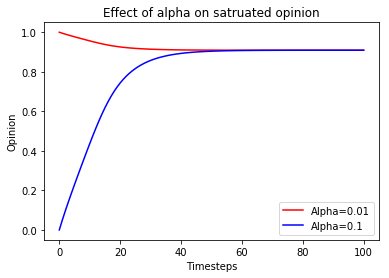

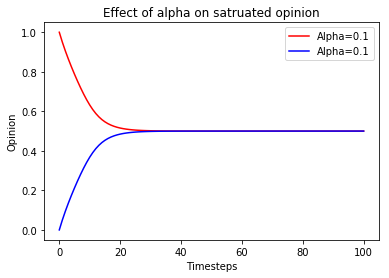

In [11]:
def plot_alpha_effect(alphas=[0.01, 0.1], beta=0.5, gamma=1, weight=0.5):
    
    opinion_0 = [1.0]
    opinion_1 = [0.0]
    timesteps = [0]
    
    for i in range(100):
        delta_o_0 = alphas[0] * weight * (opinion_1[-1] - opinion_0[-1])
        delta_o_1 = alphas[1] * weight * (opinion_0[-1] - opinion_1[-1])
        
        weight += beta * weight * (1-weight) * (1-gamma*abs(opinion_1[-1] - opinion_0[-1]))
        
        opinion_0.append(opinion_0[-1] + delta_o_0)
        opinion_1.append(opinion_1[-1] + delta_o_1)
        timesteps.append(timesteps[-1] + 1)
    
    plt.plot(timesteps, opinion_0, color='red', label='Alpha={0}'.format(alphas[0]))
    plt.plot(timesteps, opinion_1, color='blue', label='Alpha={0}'.format(alphas[1]))
    plt.xlabel('Timesteps')
    plt.ylabel('Opinion')
    plt.title('Effect of alpha on satruated opinion')
    plt.legend()
    plt.show()

plot_alpha_effect([0.01, 0.1])
plot_alpha_effect([0.1, 0.1])